
# Artifact Correction by AJDC-based Blind Source Separation

Blind source separation (BSS) based on approximate joint diagonalization of
Fourier cospectra (AJDC), applied to artifact correction of EEG [1]_.


In [1]:
# Authors: Quentin Barthélemy & David Ojeda.
# EEG signal kindly shared by Marco Congedo.
#
# License: BSD (3-clause)

import gzip
import numpy as np
from scipy.signal import welch
from matplotlib import pyplot as plt

from mne import create_info
from mne.io import RawArray
from mne.viz import plot_topomap
from mne.preprocessing import ICA

from haoze_adjc import RandAJDC
from pyriemann.utils.viz import plot_cospectra

In [2]:
def read_header(fname):
    """Read the header of sample-blinks.txt"""
    with gzip.open(fname, 'rt') as f:
        content = f.readline().split()
        return content[:-1], int(content[-1])

## Load EEG data



In [3]:
fname = 'sample-blinks.txt.gz'
signal_raw = np.loadtxt(fname, skiprows=1).T
ch_names, sfreq = read_header(fname)
ch_count = len(ch_names)
duration = signal_raw.shape[1] / sfreq

## Channel space



Using matplotlib as 2D backend.


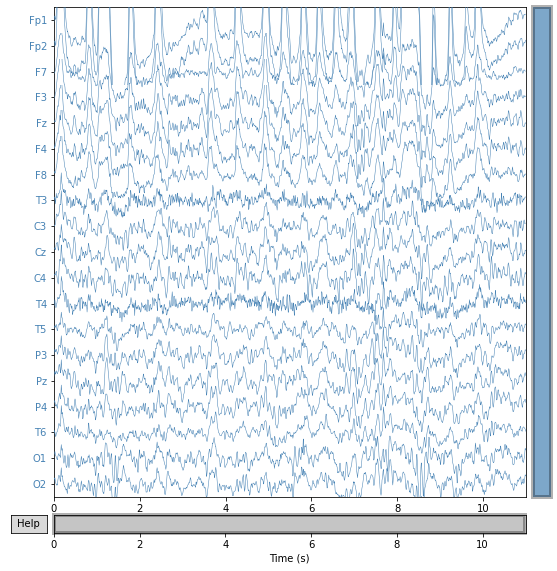

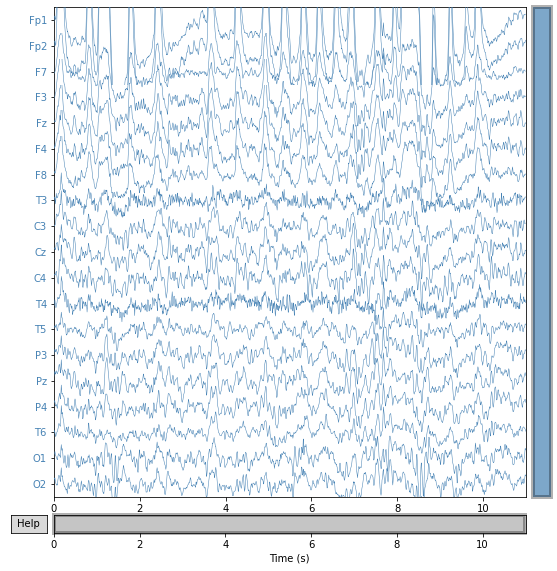

In [4]:
# Plot signal X
ch_info = create_info(ch_names=ch_names, ch_types=['eeg'] * ch_count,
                      sfreq=sfreq)
ch_info.set_montage('standard_1020')
signal = RawArray(signal_raw, ch_info, verbose=False)
signal.plot(duration=duration, start=0, n_channels=ch_count,
            scalings={'eeg': 3e1}, color={'eeg': 'steelblue'},
            title='Original EEG signal', show_scalebars=False)

In [5]:
print(signal_raw.shape)

(19, 1408)


## AJDC: Second-Order Statistics (SOS)-based BSS, diagonalizing cospectra



Condition numbers: 
 array([  1.        ,   2.8501367 ,   4.63853077,   8.19563439,
        13.78201366,  16.99958725,  18.43877655,  23.88740791,
        42.24522964,  47.27578292,  53.84409404,  70.88281337,
        86.30068795, 108.36023389, 142.8178984 , 153.62895177,
       175.57701186, 220.77734099, 257.46242498])
Dimension reduction of Whitening on 13 components


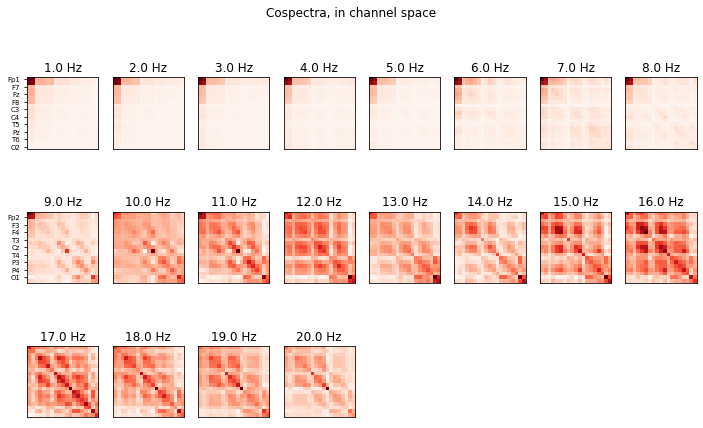

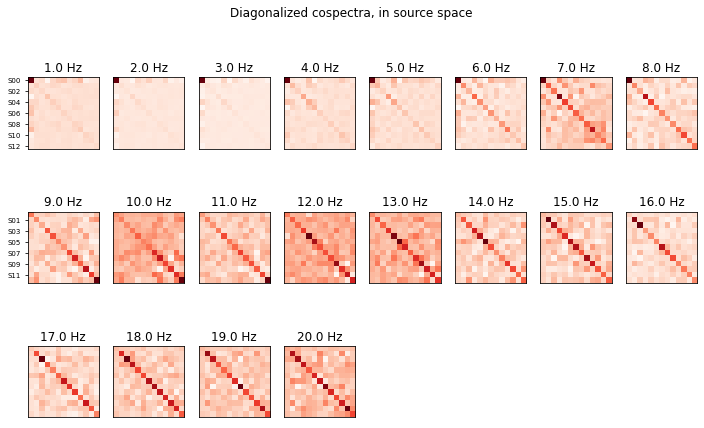

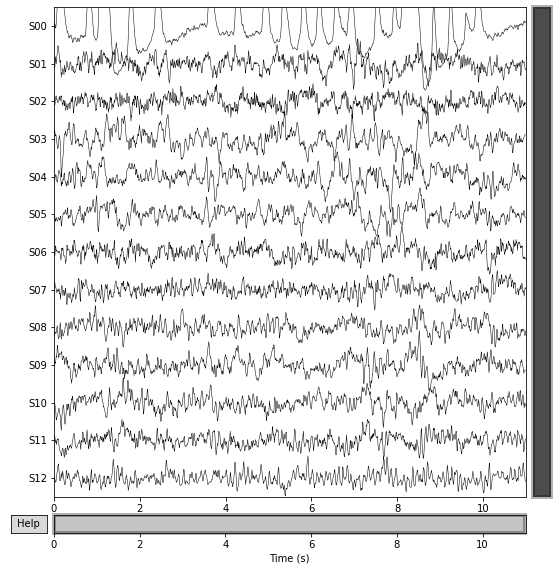

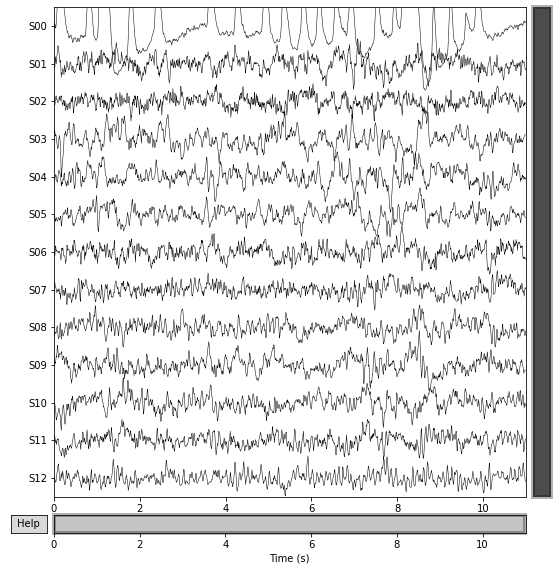

In [6]:
# Compute and diagonalize Fourier cospectral matrices between 1 and 32 Hz
window, overlap = sfreq, 0.5
fmin, fmax = 1, 20
ajdc = RandAJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
            dim_red={'max_cond': 100})
ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...])
freqs = ajdc.freqs_

# Plot cospectra in channel space, after trace-normalization by frequency: each
# cospectrum, associated to a frequency, is a covariance matrix
plot_cospectra(ajdc._cosp_channels, freqs, ylabels=ch_names,
               title='Cospectra, in channel space')
# Plot diagonalized cospectra in source space
sr_count = ajdc.n_sources_
sr_names = ['S' + str(s).zfill(2) for s in range(sr_count)]
plot_cospectra(ajdc._cosp_sources, freqs, ylabels=sr_names,
               title='Diagonalized cospectra, in source space')
# Estimate sources S applying forward filters B to signal X: S = B X
source_raw = ajdc.transform(signal_raw[np.newaxis, ...])[0]

# Plot sources S
sr_info = create_info(ch_names=sr_names, ch_types=['misc'] * sr_count,
                      sfreq=sfreq)
source = RawArray(source_raw, sr_info, verbose=False)
source.plot(duration=duration, start=0, n_channels=sr_count,
            scalings={'misc': 2e2}, title='EEG sources estimated by AJDC',
            show_scalebars=False)


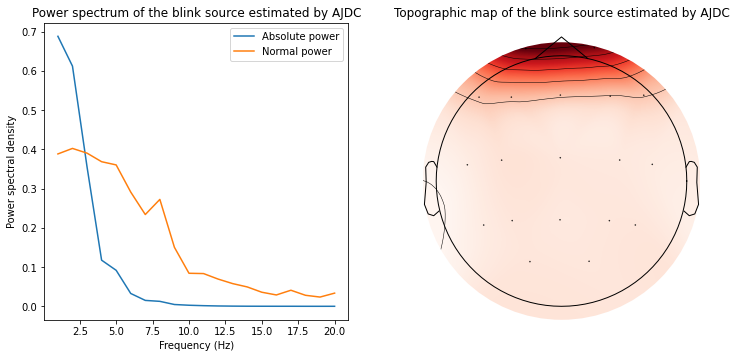

In [7]:
# Identify artifact by eye: blinks are well separated in source S0
blink_idx = 0

# Get normal spectrum, ie power spectrum after trace-normalization
blink_spectrum_norm = ajdc._cosp_sources[:, blink_idx, blink_idx]
blink_spectrum_norm /= np.linalg.norm(blink_spectrum_norm)

# Get absolute spectrum, ie raw power spectrum of the source
f, spectrum = welch(source.get_data(picks=[blink_idx]), fs=sfreq,
                    nperseg=window, noverlap=int(window * overlap))
blink_spectrum_abs = spectrum[0, (f >= fmin) & (f <= fmax)]
blink_spectrum_abs /= np.linalg.norm(blink_spectrum_abs)

# Get topographic map
blink_filter = ajdc.backward_filters_[:, blink_idx]

# Plot spectrum and topographic map of the blink source separated by AJDC
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].set(title='Power spectrum of the blink source estimated by AJDC',
           xlabel='Frequency (Hz)', ylabel='Power spectral density')
axs[0].plot(freqs, blink_spectrum_abs, label='Absolute power')
axs[0].plot(freqs, blink_spectrum_norm, label='Normal power')
axs[0].legend()
axs[1].set_title('Topographic map of the blink source estimated by AJDC')
plot_topomap(blink_filter, pos=ch_info, axes=axs[1], extrapolate='box')
plt.show()

## Source space



## Artifact identification



## Artifact correction by BSS denoising



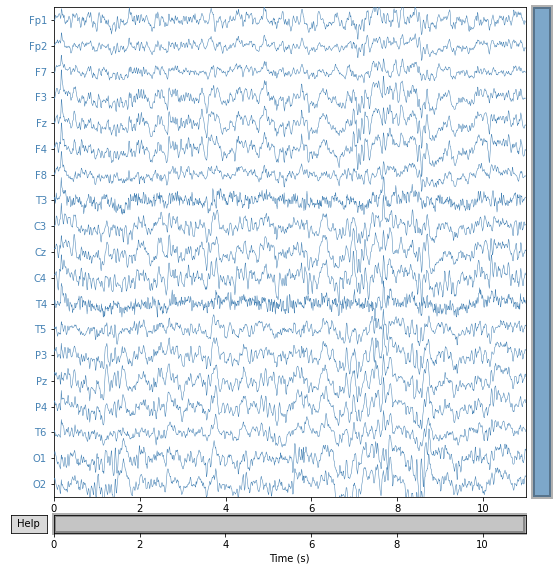

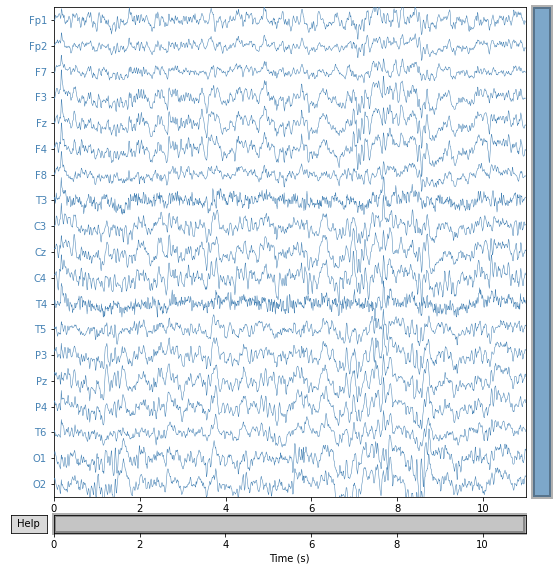

In [8]:
# BSS denoising: blink source is suppressed in source space using activation
# matrix D, and then applying backward filters A to come back to channel space
# Denoised signal: Xd = A D S
signal_denois_raw = ajdc.inverse_transform(source_raw[np.newaxis, ...],
                                           supp=[blink_idx])[0]

# Plot denoised signal Xd
signal_denois = RawArray(signal_denois_raw, ch_info, verbose=False)
signal_denois.plot(duration=duration, start=0, n_channels=ch_count,
                   scalings={'eeg': 3e1}, color={'eeg': 'steelblue'},
                   title='Denoised EEG signal by AJDC', show_scalebars=False)